# Curve Fitting Basics

One of the core principles of machine learning is to try and fit the data into a model. There are several ways of defining a model and there are multiple ways to fit the data in the model.

But fitting data into equations is not a new concept. Curve fitting has existed for a long time.
In this notebook, I wish to explore basics of curve fitting and hopefully develop this idea to be used in machine learning.

Let's define the objectives for this notebook and slowly mature the objectives.

1. Cost Function
2. Fitting data <br>
    a. Linear equation <br>
    b. Quadratic equation <br>
    c. Polynomial <br>
    d. Lagrange's method <br>
    e. Splines <br>
3. Residuals
4. Automation

## 1. Cost Function

Let's start by importing all the required libraries

In [3]:
import numpy as np
import matplotlib.pyplot as plt

Let's generate data from an equation and add some randomness to it so that it looks real

$$y = 2(x-4)^3 + 20 + noise$$

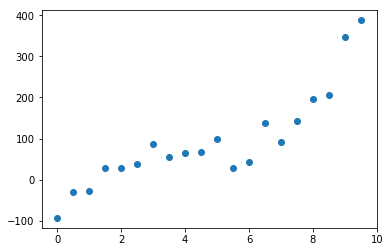

In [4]:
x = np.arange(0,10,0.5)
y = 2*(x-4)**3 + 20 + 100*np.random.rand(x.size)
plt.scatter(x,y)
plt.show()

Now if we model this equation using a linear equation $y_{pred} = ax + b$ then modelling would mean to find the values of $a$ and $b$.

For now, let us assume that $a = 25$ and $b = -10$

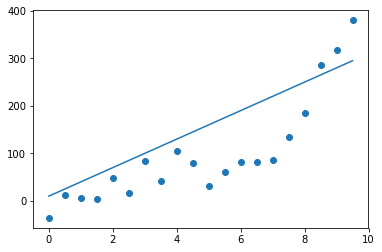

In [118]:
a = 30
b = 10
y_pred = a*x + b

plt.scatter(x,y)
plt.plot(x,y_pred)

plt.show()

Let us see how badly our model has performed w.r.t to the data. <br>
We can plot the distance of each point from the line to get a better idea of this.

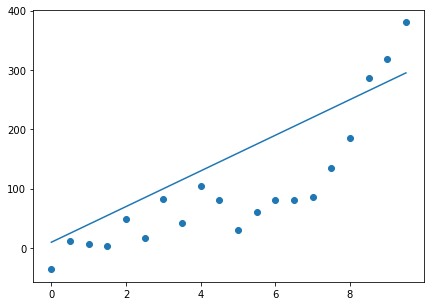

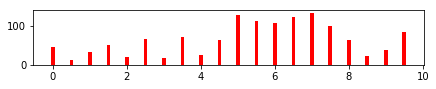

In [119]:
from matplotlib.gridspec import GridSpec

y_diff = np.abs(y - y_pred)

plt.subplots(figsize=(7,5))
plt.scatter(x,y)
plt.plot(x,y_pred)
plt.show()

plt.subplots(figsize=(7,1))
plt.bar(x,y_diff,width=0.1, align='center', color='red')
plt.show()

There multiple ways to define cost. 
1. Maximum difference between data and model
2. Root mean square error

Let's check how our model did terms of both these measures.

In [120]:
cost1 = y_diff.max()
cost2 = np.sqrt(np.sum(y_diff**2))
print(cost1)
print(cost2)

134.155758813
345.981451764


Let's try with a different model and see what happens to the cost.

In [121]:
a = 40
b = 20
y_pred = a*x + b
y_diff = np.abs(y - y_pred)

cost1 = y_diff.max()
cost2 = np.sqrt(np.sum(y_diff**2))

print(cost1)
print(cost2)

214.155758813
562.168226019


In fact, since we would want to test our model again and again for different values of $a$ and $b$, it would be beneficial to define a function for the same.

In [5]:
def model(coeff, x):
    y_pred = np.zeros(x.size)
    for i in range(0, len(coeff)):
        y_pred = y_pred + coeff[i]*x**i
        
    return y_pred

In [6]:
def objective(y, y_pred):
    cost = np.zeros(2)
    y_diff = np.abs(y - y_pred)
    cost[0] = y_diff.max()
    cost[1] = np.sqrt(np.sum(y_diff**2))
    return cost

Now lets see for different values of $a$ and $b$, what happens to the cost

In [90]:
a = np.arange(0,100,25)
b = np.arange(0,100,25)
index = 1;
print("Sr.No\ta\tb\tcost[0]\tcost[1]")
for i in range(0,a.size):
    for j in range(0,b.size):
        y_pred = model([b[j], a[i]], x)
        cost = objective(y, y_pred)
        print("%2d\t%2d\t%2d\t%4.2d\t%4.2d" % (index, a[i], b[j], cost[0], cost[1]))
        index += 1

Sr.No	a	b	cost[0]	cost[1]
 1	 0	 0	 380	 659
 2	 0	25	 355	 589
 3	 0	50	 330	 533
 4	 0	75	 305	 496
 5	25	 0	 142	 281
 6	25	25	 118	 332
 7	25	50	 143	 407
 8	25	75	 168	 497
 9	50	 0	 264	 703
10	50	25	 289	 803
11	50	50	 314	 905
12	50	75	 339	1009
13	75	 0	 439	1297
14	75	25	 464	1396
15	75	50	 489	1498
16	75	75	 514	1601


## 2. Fitting Data

As said earlier fitting data is to train the model to learn the coefficients of the model.
So if we trying to fit data into a linear model, then we are learning the coefficients of slope ($a$) and intercept ($b$).

Let's explore this idea further

### a. Linear Equation

As used earlier while making the cost function, the general form of a linear equation is
$$y = ax + b$$
Now the idea is to minimize the cost. If we consider the root mean square cost, then we have to minimize
$$f(a,b) = \sum_{k=1}^n (ax_k + b - y_k)^2$$

Since $f(a,b)$ is a function of two variables, we have to equate $\dfrac{\partial f}{\partial a} = 0$ and  $\dfrac{\partial f}{\partial b} = 0$.

This gives us,
$$
\begin{eqnarray}
\dfrac{\partial f}{\partial a} &= 2 \sum_{k=1}^n (ax_k + b - y_k) x_k &= 0 \\
\dfrac{\partial f}{\partial b} &= 2 \sum_{k=1}^n (ax_k + b - y_k) &= 0
\end{eqnarray}
$$

Simplifying these equations further,
$$
\begin{eqnarray}
a\sum_{k=1}^n x_k^2 + b \sum_{k=1}^n x_k &=&  \sum_{k=1}^n x_k y_k \\
a\sum_{k=1}^n x_k + b n &=&  \sum_{k=1}^n y_k
\end{eqnarray}
$$

If we write these equations in matrix form, we get a more concise representation,
$$
\begin{bmatrix}
\sum x_k^2  & \sum x_k\\
\sum x_k & n 
\end{bmatrix}
\begin{bmatrix}
a\\
b 
\end{bmatrix} =
\begin{bmatrix}
\sum x_k y_k\\
\sum y_k
\end{bmatrix}
$$

This is of the form $Ax = B$ and can be solve as $x = A^{-1}B$.

Enough of theory, let's try this out in code.

In [126]:
A = np.zeros((2,2))
B = np.zeros((2,1))
A[0,0] = np.sum(x**2)
A[0,1] = np.sum(x)
A[1,0] = A[0,1]
A[1,1] = x.size

B[0] = np.sum(x*y)
B[1] = np.sum(y)

X = np.matmul(np.linalg.inv(A), B)
print('A') 
print(A) 
print('-'*20)
print('B') 
print(B) 
print('-'*20)
print('X') 
print(X) 
print('-'*20)

A
[[ 617.5   95. ]
 [  95.    20. ]]
--------------------
B
[[ 14838.78505461]
 [  2007.21747638]]
--------------------
X
[[ 31.9067792 ]
 [-51.19632738]]
--------------------


Let's check the plot and cost with this model

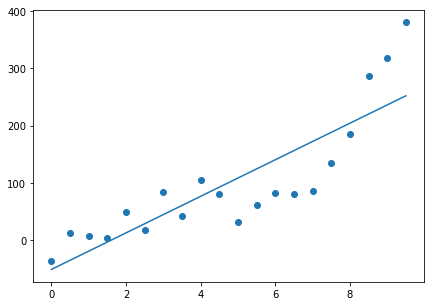

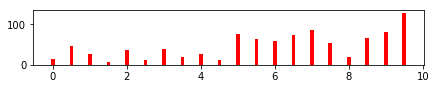

Root Mean Square cost = 254


In [127]:
y_pred = model([X[1], X[0]], x)
cost = objective(y, y_pred)

y_diff = np.abs(y - y_pred)

plt.subplots(figsize=(7,5))
plt.scatter(x,y)
plt.plot(x,y_pred)
plt.show()

plt.subplots(figsize=(7,1))
plt.bar(x,y_diff,width=0.1, align='center', color='red')
plt.show()

print('Root Mean Square cost = %d' % cost[1])

As we can, see this curve fits better than our estimate and the RMSE improves from 345 to 254

### b. Quadratic Equation

On the same lines as a linear model, the general form of the quadratic equation is 
$$y = ax^2 + bx + c$$
The cost function we have to minimize is
$$f(a,b, c) = \sum_{k=1}^n (ax_k^2 + bx_k + c - y_k)^2$$
 
Since $f(a,b,c)$ is a function of three variables, we have to equate $\dfrac{\partial f}{\partial a} = 0$, $\dfrac{\partial f}{\partial b} = 0$ and $\dfrac{\partial f}{\partial c} = 0$.

This gives us,
$$
\begin{eqnarray}
\dfrac{\partial f}{\partial a} &= 2 \sum_{k=1}^n (ax_k^2 + bx_k + c - y_k) x_k^2 &= 0 \\
\dfrac{\partial f}{\partial b} &= 2 \sum_{k=1}^n (ax_k^2 + bx_k + c - y_k) x_k &= 0 \\
\dfrac{\partial f}{\partial c} &= 2 \sum_{k=1}^n (ax_k^2 + bx_k + c - y_k) &= 0
\end{eqnarray}
$$

Simplifying these equations further,
$$
\begin{eqnarray}
a\sum_{k=1}^n x_k^4 + b \sum_{k=1}^n x_k^3 + c \sum_{k=1}^n x_k^2 &=&  \sum_{k=1}^n x_k^2 y_k \\
a\sum_{k=1}^n x_k^3 + b \sum_{k=1}^n x_k^2 + c \sum_{k=1}^n x_k &=&  \sum_{k=1}^n x_k y_k \\
a\sum_{k=1}^n x_k^2 + b \sum_{k=1}^n x_k + c n &=&  \sum_{k=1}^n y_k
\end{eqnarray}
$$

In matrix form, we get,
$$
\begin{bmatrix}
\sum x_k^4  & \sum x_k^3 & \sum x_k^2\\
\sum x_k^3  & \sum x_k^2 & \sum x_k\\
\sum x_k^2  & \sum x_k & n
\end{bmatrix}
\begin{bmatrix}
a\\
b\\
c
\end{bmatrix} =
\begin{bmatrix}
\sum x_k^2 y_k\\
\sum x_k y_k\\
\sum y_k
\end{bmatrix}
$$



In [40]:
A = np.zeros((3,3))
B = np.zeros((3,1))
A[0,0] = np.sum(x**4)
A[0,1] = np.sum(x**3)
A[0,2] = np.sum(x**2)
A[1,0] = np.sum(x**3)
A[1,1] = np.sum(x**2)
A[1,2] = np.sum(x)
A[2,0] = np.sum(x**2)
A[2,1] = np.sum(x)
A[2,2] = x.size

B[0] = np.sum(x**2 *y)
B[1] = np.sum(x*y)
B[2] = np.sum(y)

X = np.matmul(np.linalg.inv(A), B)
print('A') 
print(A) 
print('-'*20)
print('B') 
print(B) 
print('-'*20)
print('X') 
print(X) 
print('-'*20)

A
[[  3.51666250e+04   4.51250000e+03   6.17500000e+02]
 [  4.51250000e+03   6.17500000e+02   9.50000000e+01]
 [  6.17500000e+02   9.50000000e+01   2.00000000e+01]]
--------------------
B
[[ 118189.3478239 ]
 [  14831.53486587]
 [   1899.94922529]]
--------------------
X
[[  3.97725501]
 [ -2.85594637]
 [-14.23454188]]
--------------------


Let's check our model

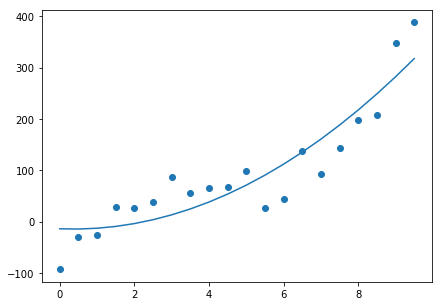

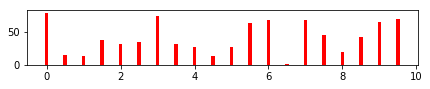

Root Mean Square cost = 213


In [41]:
y_pred = model([X[2], X[1], X[0]], x)
cost = objective(y, y_pred)

y_diff = np.abs(y - y_pred)

plt.subplots(figsize=(7,5))
plt.scatter(x,y)
plt.plot(x,y_pred)
plt.show()

plt.subplots(figsize=(7,1))
plt.bar(x,y_diff,width=0.1, align='center', color='red')
plt.show()

print('Root Mean Square cost = %d' % cost[1])

We can see that our model fits the data very well.

### 3. Polynomial model

Let's take it to the next step with building a generic solution for any order of equation.
That's right. We want to build a algorithm to fit data with the order of equation we supply to it.

As you must have seen with the linear and quadratic model, it is very easy to see the pattern and directly come up with the matrix equation that can be used to fit a $n^{th}$ order polynomial.

$$
\begin{bmatrix}
\sum x_k^{2n}  & \sum x_k^{2n-1} & \ldots & \sum x_k^{n}\\
\sum x_k^{2n-1}  & \sum x_k^{2n-2} & \ldots & \sum x_k^{n-1}\\
\vdots  & \vdots  & \ddots & \vdots\\
\sum x_k^n  & \sum x_k^{n-1} & \ldots  & n
\end{bmatrix}
\begin{bmatrix}
a_1\\
a_2\\
\vdots \\
a_{n+1}
\end{bmatrix} =
\begin{bmatrix}
\sum x_k^{n} y_k\\
\sum x_k^{n-1} y_k\\
\vdots \\
\sum y_k
\end{bmatrix}
$$

In [48]:
def PolyFit(x, y, n):
    AllSums = np.zeros(2*n+1)
    for i in range(0, 2*n + 1):
        AllSums[i] = np.sum(x**i)

    A = np.zeros((n+1, n+1))
    for i in range(0,n+1):
        for j in range(0,n+1):
            A[i,j] = AllSums[2*n-i-j]

    B = np.zeros((n+1,1))        
    for i in range(0,n+1):
        B[i] = np.sum(x**(n-i) *y)

    X = np.matmul(np.linalg.inv(A), B)
    X = X[::-1]
    return X

In [61]:
X = PolyFit(x,y,6)

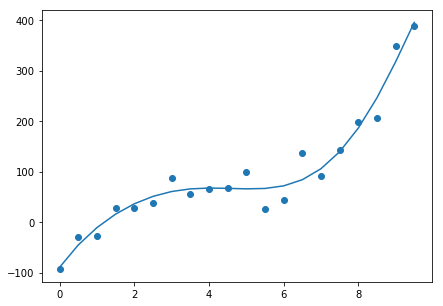

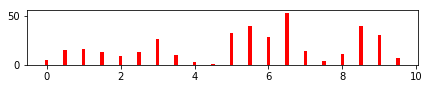

Root Mean Square cost = 104


In [62]:
y_pred = model(X, x)
cost = objective(y, y_pred)

y_diff = np.abs(y - y_pred)

plt.subplots(figsize=(7,5))
plt.scatter(x,y)
plt.plot(x,y_pred)
plt.show()

plt.subplots(figsize=(7,1))
plt.bar(x,y_diff,width=0.1, align='center', color='red')
plt.show()

print('Root Mean Square cost = %d' % cost[1])

As can be seen the polynomial fit works perfectly and gives a very good fit.